# Predicting which Canadian province will have the highest percentage of COVID-19 recoveries
### Group Members
Jason Ji (69217222), Mikayla Chau (29043288), Linda Zhang (95711800), Alireza Mohammadi (20700985)

In [56]:
set.seed(36)
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

### Intoduction

COVID-19 is an infectious disease caused by the SARS-CoV-2 virus (Government of Canada). The first known case was identified in Wuhan, China, on December 12th 2019 (CDC Museum Covid-19 Timeline). The disease quickly spread worldwide, resulting in the COVID-19 pandemic. Canada has also been severely impacted by COVID-19. According to the Government of Canada, some people are at higher risk of more severe disease or outcomes from COVID-19 than others. Although there are a number of available vaccines and treatments, there were nearly 4,300,000 infected people by the end of September, 2022. Ontario has the highest total number of infected people, at nearly 1,470,000, however, the total number of infected people in Nunavut is just 3531 (Government of Canada). Because the Yukon, Northwest Territories and Nunavut are three provinces that are close to the Arctic Circle, there are not as many people living there compared to the other 10 provinces, which causes a huge difference in the number of the total infected people. This means that comparing the absolute number of recoveries would lead to a biased data set; the number of recoveries in Ontario will be more than recoveries in Nunavut solely because there are more people. As such, we will be comparing the percent recovered from COVID-19, allowing for a fairer playing field across the provinces.

In this project, we will try to predict which Canadian province will have the highest percentage of COVID-19 recoveries in December 2022. In order to do so we will investigate public health information gathered from different Canadian provinces from the end of January 2020 to the end of December 2021, and create a classification model able to predict which province has the highest percent recovery rate. Then once that model has been trained and tested, we will complete one last test on COVID-19 data for December 2022, ensuring our model works.

The dataset we used for this project was taken from https://health-infobase.canada.ca/ (Government of Canada) based on data that provincial and territorial partners published on cases and deaths. This data contains daily information of COVID-19 cases from February 2020 until October 2022. There are 7 important properties for each data report:

1. province : Canada province/territory (P/T) from which the information was reported, containing names of 13 Canadian provinces and territories.
2. date : Date of recorded observation
3. numconf : Number of confirmed cases in each P/T (Canada= sum of all P/T)
4. numprob : Number of probable cases in each P/T (Canada= sum of all P/T)
5. numdeaths : Number of deaths in each P/T (Canada= sum of all P/T)
6. numtotal : Total number of cases, calculated by number of confirmed cases plus number of probable cases.
7. Percentrecover : Percentage of recovered cases, Calculated by the number of recovered cases for P/T divided by the total number of confirmed cases for that P/T [(numrecover/numtotal) * 100]

As of October 21, 2022, 9 am ET,Public Health Agency of Canada(PHAC) has received detailed case report data on 4,135,488 cases.



References:

Public Health Agency. “Government of Canada.” Canada.ca, Government of Canada, 18 Aug. 2022, https://www.canada.ca/en/public-health/services/diseases/2019-novel-coronavirus-infection.html
“CDC Museum Covid-19 Timeline.” David J. Sencer CDC Museum: In Association with the Smithsonian Institution, Centers for Disease Control and Prevention, 16 Aug. 2022, https://www.cdc.gov/museum/timeline/covid19.html. 

### Preliminary Data Analysis

The data is mostly tidy, however there are many columns we do not need for our analysis. Tidying the data included taking out these unwanted columns, any unwanted rows (Canada and Repatriated Travellers), and changing some column names to make it more reader-friendly. First, we read the data into R (NOTE: This data is for January 31, 2020 to December 17, 2021).

In [57]:
covid <- read_csv("canada-covid-19.csv")
covid

Rows: 9762 Columns: 40
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (3): prname, prnameFR, percentrecover
dbl  (36): pruid, update, numconf, numprob, numdeaths, numtotal, numtested, ...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


pruid prname                 prnameFR             date       update
1    35    Ontario                Ontario              2020-01-31 NA    
2    59    British Columbia       Colombie-Britannique 2020-01-31 NA    
3     1    Canada                 Canada               2020-01-31 NA    
⋮    ⋮     ⋮                      ⋮                    ⋮          ⋮     
9760 62    Nunavut                Nunavut              2021-12-17  1    
9761 99    Repatriated travellers Voyageurs rapatriés  2021-12-17 NA    
9762  1    Canada                 Canada               2021-12-17 NA    
     numconf numprob numdeaths numtotal numtested ⋯ ratedeaths_last14
1    3       0       0         3        NA        ⋯ NA               
2    1       0       0         1        NA        ⋯ NA               
3    4       0       0         4        NA        ⋯ NA               
⋮    ⋮       ⋮       ⋮         ⋮        ⋮         ⋱ ⋮                
9760     676 NA          4         676  NA        ⋯ 0.00             
9761      13 NA          0          13  NA        ⋯   NA             
9762 1866907 NA      30032     1866907  NA        ⋯ 0.72             
     numtotal_last7 ratetotal_last7 numdeaths_last7 ratedeaths_last7
1    NA             NA              NA              NA              
2    NA             NA              NA              NA              
3    NA             NA              NA              NA              
⋮    ⋮              ⋮               ⋮               ⋮               
9760     0            0.00            0             0.00            
9761     0              NA            0               NA            
9762 39216          102.54          132             0.35            
     avgtotal_last7 avgincidence_last7 avgdeaths_last7 avgratedeaths_last7
1    NA             NA                 NA              NA                 
2    NA             NA                 NA              NA                 
3    NA             NA                 NA              NA                 
⋮    ⋮              ⋮                  ⋮               ⋮                  
9760    0            0.00               0              0.00               
9761    0              NA               0                NA               
9762 5602           14.65              19              0.05               
     raterecovered
1    0            
2    0            
3    0            
⋮    ⋮            
9760  0.00        
9761    NA        
9762 10.85

Next, we tidy our data, keeping only the columns we will use for our model.

In [58]:
tidy_covid <- covid |> 
    mutate(province = prname) |>
    mutate(percentrecover = as.numeric(percentrecover)) |>
    select(province, date, numconf, numprob, numdeaths, numtotal, percentrecover) |>
    filter(province != "Repatriated travellers") |>
    filter(province != "Canada") |>
    group_by(province)
tidy_covid

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


province              date       numconf numprob numdeaths numtotal
1    Ontario               2020-01-31 3       0       0         3       
2    British Columbia      2020-01-31 1       0       0         1       
3    Ontario               2020-02-08 3       0       0         3       
⋮    ⋮                     ⋮          ⋮       ⋮       ⋮         ⋮       
8450 Yukon                 2021-12-17 1621    NA      14        1621    
8451 Northwest Territories 2021-12-17 2082    NA      12        2082    
8452 Nunavut               2021-12-17  676    NA       4         676    
     percentrecover
1    NA            
2    NA            
3    NA            
⋮    ⋮             
8450 96.79         
8451 98.75         
8452 99.26

Next, we split our data set into a training and testing set, ensuring our model will not be affected by the data we will test it with.

In [59]:
covid_split <- initial_split(tidy_covid, prop = 0.75, strata = province)
covid_train <- training(covid_split)
covid_test <- testing(covid_split)
covid_train
covid_test

Warning message:
“Too little data to stratify.
• Resampling will be unstratified.”


province              date       numconf numprob numdeaths numtotal
1    Ontario               2020-01-31 3       0       0         3       
2    British Columbia      2020-01-31 1       0       0         1       
3    Ontario               2020-02-16 3       0       0         3       
⋮    ⋮                     ⋮          ⋮       ⋮       ⋮         ⋮       
6337 Yukon                 2021-12-17 1621    NA      14        1621    
6338 Northwest Territories 2021-12-17 2082    NA      12        2082    
6339 Nunavut               2021-12-17  676    NA       4         676    
     percentrecover
1    NA            
2    NA            
3    NA            
⋮    ⋮             
6337 96.79         
6338 98.75         
6339 99.26

province             date       numconf numprob numdeaths numtotal
1    Ontario              2020-02-08 3       0       0         3       
2    British Columbia     2020-02-08 4       0       0         4       
3    British Columbia     2020-02-16 5       0       0         5       
⋮    ⋮                    ⋮          ⋮       ⋮       ⋮         ⋮       
2111 Prince Edward Island 2021-12-16   444   NA         0        444   
2112 Manitoba             2021-12-17 70785   NA      1360      70785   
2113 New Brunswick        2021-12-17 10313   NA       146      10313   
     percentrecover
1    NA            
2    NA            
3    NA            
⋮    ⋮             
2111 88.96         
2112 95.54         
2113 86.40

### Summary Tables

The below table documents the average, minimum, and maximum values of each column.

In [60]:
obs_num_summary <- group_by(covid_train, province)%>%
                            summarize( 
                             min_conf = min(numconf, na.rm = TRUE),
                             mean_conf = mean(numconf,na.rm = TRUE),
                             most_conf = max(numconf, na.rm = TRUE),
                             min_death = min(numdeaths, na.rm = TRUE),
                             mean_death = mean(numdeaths,na.rm = TRUE),
                             most_death = max(numdeaths, na.rm = TRUE),
                             min_total = min(numtotal, na.rm = TRUE),
                             mean_death = mean(numtotal,na.rm = TRUE),
                             most_total = max(numtotal, na.rm = TRUE),
                             )
obs_num_summary

province         min_conf mean_conf   most_conf min_death mean_death 
1  Alberta          14       130984.11   341023    0         130976.36  
2  British Columbia  1        78322.58   225785    0          78322.58  
3  Manitoba          0        28092.25    70539    0          28095.17  
⋮  ⋮                ⋮        ⋮           ⋮         ⋮         ⋮          
11 Quebec           1        221218.1320 478246    0         221220.5680
12 Saskatchewan     0         27265.9607  82069    0          27266.1260
13 Yukon            0           245.4528   1621    0            245.4528
   most_death min_total most_total
1  3286       14        341023    
2  2399        1        225785    
3  1359        0         70539    
⋮  ⋮          ⋮         ⋮         
11 11634      1         478246    
12   942      1          82069    
13    14      0           1621

This table collects the number of observations for each province, ordering from most to least.

In [71]:
province_obs <- group_by(covid_train,province)%>%
summarize(num_obs=n()) |>
arrange(by = desc(num_obs))
province_obs

province                  num_obs
1  Alberta                   502    
2  Northwest Territories     502    
3  Quebec                    500    
4  Ontario                   495    
5  Manitoba                  493    
6  Newfoundland and Labrador 486    
7  Nova Scotia               486    
8  Prince Edward Island      486    
9  British Columbia          484    
10 Saskatchewan              484    
11 Nunavut                   479    
12 New Brunswick             476    
13 Yukon                     466

This table records how much missing data there is and in which columns they occur.

In [62]:
missing <- covid_train %>% summarise_all(~ sum(is.na(.)))
missing

province         date numconf numprob numdeaths numtotal percentrecover
1  Alberta          0    0       181     0         0        22            
2  British Columbia 0    0       164     0         0        23            
3  Manitoba         0    0       177     0         0        23            
⋮  ⋮                ⋮    ⋮       ⋮       ⋮         ⋮        ⋮             
11 Quebec           0    0       165     0         0        27            
12 Saskatchewan     0    0       167     0         0        19            
13 Yukon            0    0       161     0         0        23

### Visualization

Before we completed the visualization, we had to mutate the data slightly, finding the overall average recovery rate for each province.

In [63]:
options(repr.plot.width = 10, repr.plot.height = 8)
options(repr.matrix.max.rows = 15)
recover_table <- covid_train |> 
    mutate(mean_percent = mean(percentrecover, na.rm = TRUE)) |>
    select(province, mean_percent) |>
    group_by(province) |>
    summarize(mean_percent = mean(mean_percent)) 
recover_table

province                  mean_percent
1  Alberta                   87.80650    
2  British Columbia          86.47937    
3  Manitoba                  82.33538    
4  New Brunswick             88.97628    
5  Newfoundland and Labrador 93.20139    
6  Northwest Territories     91.35557    
7  Nova Scotia               89.89841    
8  Nunavut                   89.78599    
9  Ontario                   88.80849    
10 Prince Edward Island      93.13359    
11 Quebec                    81.83740    
12 Saskatchewan              86.96510    
13 Yukon                     91.25158

For the visualization itself, we plotted the province name against the over average recovery rate. This visualization shows that there is a relationship between recovery rates and province (different provinces and territories have different recovery rates), demonstrating that we will be able to identify the province with the highest recovery rate, whether overall, month-by-month, or even day-by-day.

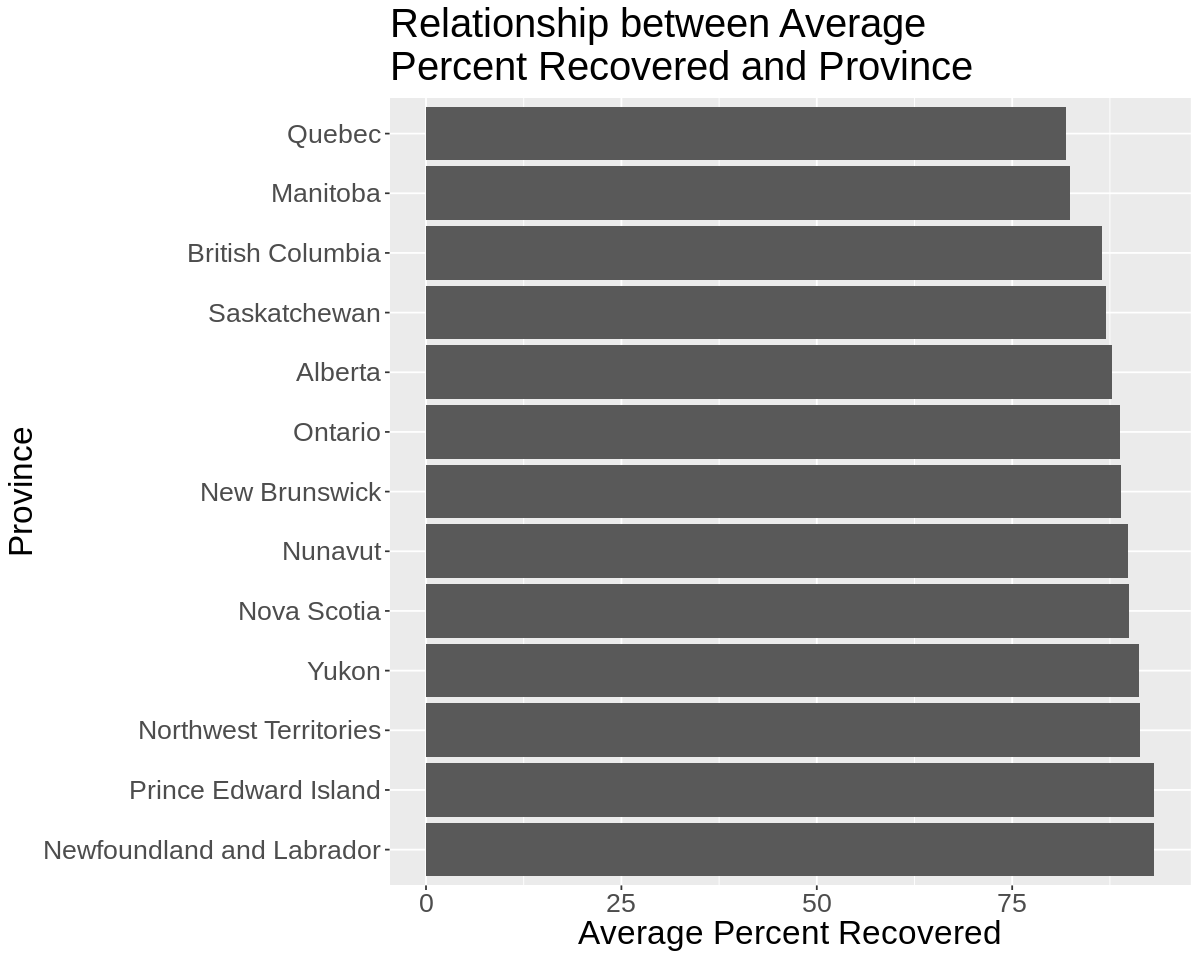

In [64]:
recover_plot <- recover_table |>
ggplot(aes(x = fct_reorder(province, mean_percent, .desc = TRUE), y = mean_percent)) +
        geom_bar(stat = "identity")+
        labs(x = "Province", y = "Average Percent Recovered", fill = "Province")+
        theme(text = element_text(size = 20))+
        coord_flip()+
    ggtitle("Relationship between Average \nPercent Recovered and Province")
recover_plot

### Methods

For our data analysis, we will split the COVID-19 data (dating from January 31, 2020, to December 17, 2021) into a testing and training set. Next, we will use the date, number confirmed, number probable, number of deaths, total number, and percent recovered to train our data to predict which province the data is describing. 

THIS IS NOT DONE: CONSULT GROUP MEMBERS

### Expected Outcomes and Significance

We believe that the Maritime provinces (Nova Scotia, Newfoundland and Labrador, PEI, New Brunswick) will have the highest COVID-19 recovery rates. They have a smaller population and likely have a healthcare system that will not be overwhelmed by COVID-19 cases.
After finding which province that has the highest recovery rate, we can infer which province has handled COVID-19 the best and identify the provinces that need more support or response strategies. 

Future questions:

1. Why does the identified province have the highest recovery rate? 
2. Does the recovery rate relate to other categorical variables that show a considerable difference between the province with highest recovery rate and others? (response times, types of restrictions, healthcare system, etc.)
3. Can the successes of this province be adapted to help improve the recovery rates of other provinces?
